(sbvd)=
# Modelling Approximation Uncertainty

In [1]:
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt

# Vector Graphics
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import matplotlib.cm as cm
from itertools import chain, combinations
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<div align="justify">

Bayesian inference can be seen as the main representative of probabilistic methods and provides a coherent framework for statistical reasoning that is well-established in machine learning (and beyond). Version space learning can be seen as a “logical” (and in a sense simplified) counterpart of Bayesian inference, in which hypotheses and predictions are not assessed numerically in terms of probabilities, but only qualified (deterministically) as being possible or impossible. In spite of its limited practical usefulness, version space learning is interesting for various reasons. In particular, in light of our discussion about uncertainty, it constitutes an interesting case: By construction, version space learning is free of aleatoric uncertainty, i.e., all uncertainty is epistemic.

</div>

(vsl)=
## Version Space Learning

<div align="justify">

In the idealized setting of version space learning, we assume a deterministic dependency $f^*:\, \cX \longrightarrow \cY$,  i.e., the distribution {eq}`ccp` degenerates to

$$
P( y \vert \vec{x}_{q}) = \left\{ \begin{array}{ll}
1 & \text{ if } y = f^*(\vec{x}_{q}) \\
0 & \text{ if } y \neq f^*(\vec{x}_{q}) \\
\end{array} \right.
$$(ccpvs)

Moreover, the training data {eq}`td` is free of noise. Correspondingly, we also assume that classifiers produce deterministic predictions $h(\vec{x}) \in \{ 0, 1 \}$ in the form of probabilities 0 or 1. Finally, we assume that $f^* \in \cH$, and therefore $h^* = f^*$ (which means there is no model uncertainty).

</div>

<div align="justify">

Under these assumptions, a hypothesis $h \in \cH$ can be eliminated as a candidate as soon as it makes at least one mistake on the training data: in that case, the risk of $h$ is necessarily higher than the risk of $h^*$ (which is 0). The idea of the candidate elimination algorithm ({cite:t}`mitc_vs77`) is to maintain the *version space* $\mathcal{V} \subseteq \cH$ that consists of the set of all hypotheses consistent with the data seen so far:

$$
\mathcal{V} = \mathcal{V}(\cH , \cD) = \{ h \in \cH \with h(\vec{x}_i) = y_i \text{ for } i = 1, \ldots , N \Big\}
$$

Obviously, the version space is shrinking with an increasing amount of training data, i.e., $\mathcal{V}(\cH , \cD') \subseteq \mathcal{V}(\cH , \cD)$ for $\cD \subseteq \cD'$. 

</div>

<div align="justify">

If a prediction $\hat{y}_{q}$ for a query instance $\vec{x}_{q}$ is sought, this query is submitted to all members $h \in \mathcal{V}$ of the version space. Obviously, a unique prediction can only be made if all members agree on the outcome of $\vec{x}_{q}$. Otherwise, several outcomes $y \in \mathcal{Y}$ may still appear possible. Formally, mimicking the logical conjunction with the minimum operator and the existential quantification with a maximum, we can express the degree of possibility or plausibility of an outcome $y \in \mathcal{Y}$ as follows ($\llbracket \cdot \rrbracket$ denotes the indicator function):

$$
\pi(y) := \max_{h \in \cH} \min \Big( \llbracket h \in \mathcal{V} \rrbracket , \llbracket h(\vec{x}_q) = y \rrbracket \Big)
$$(ee1)

Thus, $\pi(y)=1$ if there exists a candidate hypothesis $h \in \mathcal{V}$ such that $h(\vec{x}_{q}) = y$, and $\pi(y)=0$ otherwise. In other words, the prediction produced in version space learning is a subset

$$
Y = Y(\vec{x}_q) := \{ h(\vec{x}_q) \vert h \in \mathcal{V} \} = \{ y \vert \pi(y) = 1 \} \subseteq \mathcal{Y}
$$(vss)

See {numref}`vs` for an illustration.

</div>

:::{figure-md} vs
<img src="pic-version-space.png" alt="version-space" width="600px">

Illustration of version space learning inference. The version space $\mathcal{V}$, which is the subset of hypotheses consistent with the data seen so far, represents the state of knowledge of the learner. For a query $\vec{x}_{q} \in \mathcal{X}$, the set of possible predictions is given by the set $Y = \{ h(\vec{x}_q) \given h \in \mathcal{V}\}$. The distribution on the right is the characteristic function $\pi:\, \mathcal{Y} \longrightarrow \{ 0,1 \}$ of this set, which can be interpreted as a $\{0,1\}$-valued possibility distribution (indicating whether $y$ is a possible outcome or not, i.e., $\pi(y) = \llbracket y \in Y \rrbracket$).
:::

<div align="justify">

Here's an example about how to use the version space algorithm to classify weather data. We will start by generating and visualizing a dataset, define and update the version space, and finally use the version space to make predictions.

</div>

<div align="justify">

First, we generate some data with temperature and humidity as features, and weather type (sunny or rainy) as labels.
    
</div>

In [2]:
X = np.array([
    [30, 70], [25, 65], [20, 80], [15, 90], [10, 85],  # Features (e.g., temperature, humidity)
    [35, 60], [40, 55], [45, 50], [50, 45], [55, 40]
])
Y = np.array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0])  # Labels (e.g., sunny=1, rainy=0)

training_data = list(zip(X, Y))

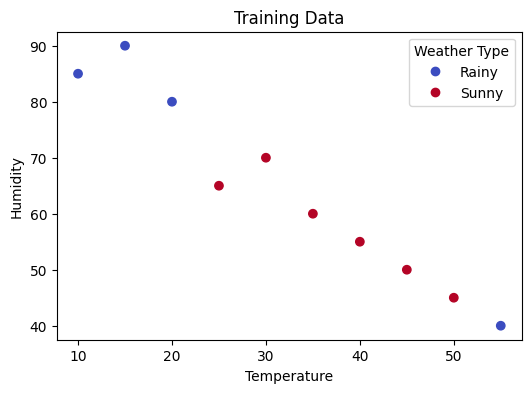

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))

scatter = ax.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm')
ax.set_title('Training Data')
ax.set_xlabel('Temperature')
ax.set_ylabel('Humidity')

legend_labels = ['Rainy', 'Sunny']
handles = scatter.legend_elements()[0]
ax.legend(handles, legend_labels, title="Weather Type")

plt.show()

<div align="justify">

We also define the initial version space, which contains several possible rules. Each rule in the version space is represented by a range of temperature and humidity. A range acts as a boundary distinguishing between positive examples (sunny days) and negative examples (rainy days).

</div>

In [4]:
# Initial version space
version_space = [
    {'temp_range': (15, 35), 'humidity_range': (60, 80)},
    {'temp_range': (0, 20), 'humidity_range': (75, 100)},
    {'temp_range': (25, 50), 'humidity_range': (0, 70)},
    {'temp_range': (0, 25), 'humidity_range': (70, 100)},
    {'temp_range': (30, 60), 'humidity_range': (0, 65)},
    {'temp_range': (0, 30), 'humidity_range': (65, 100)},
    {'temp_range': (20, 60), 'humidity_range': (45, 75)},
    {'temp_range': (20, 45), 'humidity_range': (55, 90)},
    {'temp_range': (0, 40), 'humidity_range': (70, 100)}
]


<div align="justify">

We now define a function to update the version space based on the training data. The function removes rules that are inconsistent with the training examples. Suppose through a series of training data, which includes both sunny and rainy conditions, the version space algorithm ultimately narrows down to a specific set of rules. These rules may form boundaries around specific combinations of temperature and humidity.

The final version space should: 
1. Cover all positives: The rules within the final version space must cover all data points labeled as positive, ensuring that these points are correctly classified as positive examples.
2. Exclude all negatives: The rules within the final version space should not encompass any data points labeled as negative, ensuring that these points are correctly classified as negative examples.

</div>

In [5]:
def update_version_space(version_space, x, y):
    updated_space = []
    for rule in version_space:
        temp_min, temp_max = rule['temp_range']
        humidity_min, humidity_max = rule['humidity_range']
        if y == 1:  
            if temp_min <= x[0] <= temp_max and humidity_min <= x[1] <= humidity_max:
                updated_space.append(rule)
        else: 
            if not (temp_min <= x[0] <= temp_max and humidity_min <= x[1] <= humidity_max):
                updated_space.append(rule)
    return updated_space

current_version_space = version_space

for x, y in training_data:
    current_version_space = update_version_space(current_version_space, x, y)
    if not current_version_space:
        print("No hypotheses left in the version space.")
        break

<div align="justify">

Now we visualize the initial and updated version space using rectangles to represent the ranges of temperature and humidity. Each rectangle represents a rule that defines a range for temperature and humidity:

Horizontal Axis: Represents the range of temperature. The horizontal width of the rectangle extends from the minimum temperature value to the maximum temperature value.

Vertical Axis: Represents the range of humidity. The vertical height of the rectangle extends from the minimum humidity value to the maximum humidity value.

</div>

After updating, the final version space contains:
[{'temp_range': (25, 50), 'humidity_range': (0, 70)}, {'temp_range': (20, 60), 'humidity_range': (45, 75)}]


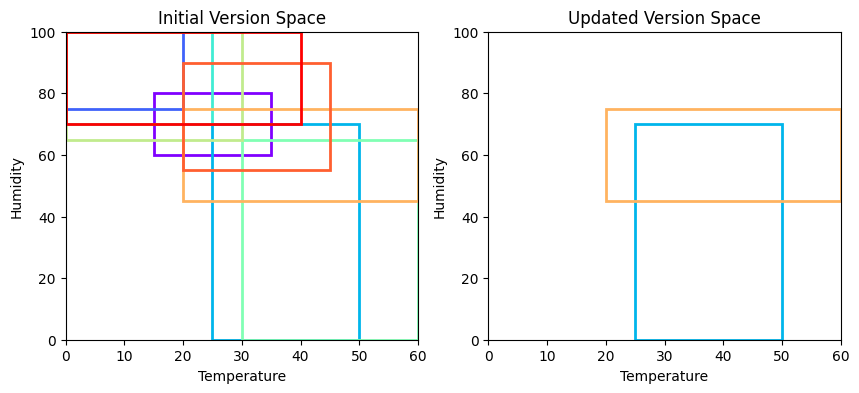

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

colors = cm.rainbow(np.linspace(0, 1, len(version_space)))
rule_to_color = {str(rule): color for rule, color in zip(version_space, colors)}

for rule in version_space:
    temp_min, temp_max = rule['temp_range']
    humidity_min, humidity_max = rule['humidity_range']
    color = rule_to_color[str(rule)]
    rect = plt.Rectangle((temp_min, humidity_min), temp_max-temp_min, humidity_max-humidity_min, fill=False, edgecolor=color, linewidth=2)
    ax[0].add_patch(rect)
ax[0].set_title('Initial Version Space')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Humidity')
ax[0].set_xlim(0, 60)
ax[0].set_ylim(0, 100)

for rule in current_version_space:
    temp_min, temp_max = rule['temp_range']
    humidity_min, humidity_max = rule['humidity_range']
    color = rule_to_color[str(rule)]
    rect = plt.Rectangle((temp_min, humidity_min), temp_max-temp_min, humidity_max-humidity_min, fill=False, edgecolor=color, linewidth=2)
    ax[1].add_patch(rect)
ax[1].set_title('Updated Version Space')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel('Humidity')
ax[1].set_xlim(0, 60)
ax[1].set_ylim(0, 100)
print("After updating, the final version space contains:")
print(current_version_space)
plt.show()


<div align="justify">

Finally, we define a function to make predictions based on the updated final version space and test it with a new sample(temperature=25, humidity=68). The "predict" function iterates over each rule in the final version space and checks if the new sample falls within the temperature and humidity range specified by the rule. The function returns the list of predictions, "0" for "Rainy" and "1" for "Sunny". We check the predictions list to see if 0 or 1 is present. If present, we set the corresponding possibility to 1, otherwise to 0.
</div>

In [7]:
def predict(version_space, x):
    if not version_space:
        return None  
    predictions = []
    for rule in version_space:
        temp_min, temp_max = rule['temp_range']
        humidity_min, humidity_max = rule['humidity_range']
        if temp_min <= x[0] <= temp_max and humidity_min <= x[1] <= humidity_max:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions  

# New sample
new_sample = [25, 68]
predictions = predict(current_version_space, new_sample)

# Representing the possibility of outcomes
outcomes = ["Rainy", "Sunny"]
if predictions is None:
    outcome_possibility = [0, 0]
else:
    outcome_possibility = [1 if i in predictions else 0 for i in [0, 1]]


The possibility for two classes(rainy or sunny) is: [0, 1]


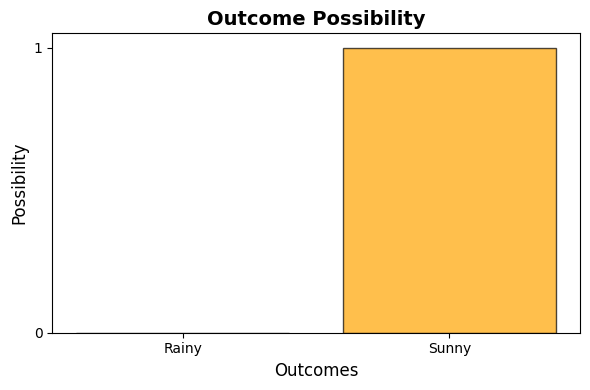

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(outcomes, outcome_possibility, color=['orange'], alpha=0.7, edgecolor='black')
ax.set_title('Outcome Possibility', fontsize=14, fontweight='bold')
ax.set_xlabel('Outcomes', fontsize=12)
ax.set_ylabel('Possibility', fontsize=12)
ax.set_yticks([0, 1]) 

print(f"The possibility for two classes(rainy or sunny) is: {outcome_possibility}")
plt.tight_layout()
plt.show()

<div align="justify">

Note that the inference {eq}`ee1` can be seen as a kind of constraint propagation, in which the constraint $h \in \mathcal{V}$ on the hypothesis space $\cH$ is propagated to a constraint on $\cY$, expressed in the form of the subset {eq}`vss` of possible outcomes; or symbolically:

$$
\cH , \cD , \vec{x}_{q}  \models Y
$$(cbi)

This view highlights the interaction between prior knowledge and data: It shows that what can be said about the possible outcomes $y_{q}$ not only depends on the data $\cD$ but also on the hypothesis space $\cH$, i.e., the *model assumptions* the learner starts with. The specification of $\mathcal{H}$ always comes with an *inductive bias*, which is indeed essential for learning from data {cite:t}`mitc_tn80`. In general, both aleatoric and epistemic uncertainty (ignorance) depend on the way in which prior knowledge and data interact with each other. Roughly speaking, the stronger the knowledge the learning process starts with, the less data is needed to resolve uncertainty. In the extreme case, the true model is already known, and data is completely superfluous. Normally, however, prior knowledge is specified by assuming a certain type of model, for example a linear relationship between inputs $\vec{x}$ and outputs $y$. Then, all else (namely the data) being equal, the degree of predictive uncertainty depends on how flexible the corresponding model class is. Informally speaking, the more restrictive the model assumptions are, the smaller the uncertainty will be. This is illustrated in {numref}`vsli` for the case of binary classification.

</div>

:::{figure-md} vsli
<img src="combined_figure.png" alt="version-space" width="600px">

Two examples illustrating predictive uncertainty in version space learning for the case of binary classification.
In the first example (above), the hypothesis space is given in terms of rectangles (assigning interior instances to the positive class and instances outside to the negative class). Both pictures show some of the (infinitely many) elements of the version space. Top left: Restricting $\mathcal{H}$ to axis-parallel rectangles, the first query point is necessarily positive, the second one necessarily negative, because these predictions are produced by all $h \in \mathcal{V}$. As opposed to this, both positive and negative predictions can be produced for the third query. Top right: Increasing flexibility (or weakening prior knowledge) by enriching the hypothesis space and also allowing for non-axis-parallel rectangles, none of the queries can be classified with certainty anymore. In the second example (below), hypotheses are linear and quadratic discriminant functions, respectively. Bottom left: If the hypothesis space is given by linear discriminant functions, all hypothesis consistent with the data will predict the query instance as positive. Bottom right: Enriching the hypothesis space with quadratic discriminants, the members of the version space will no longer vote unanimously: some of them predict the positive and others the negative class.
:::

<div align="justify">

Coming back to our discussion about uncertainty, it is clear that version space learning as outlined above does not involve any kind of aleatoric uncertainty. Instead, the only source of uncertainty is a lack of knowledge about $h^*$, and hence of epistemic nature. On the model level, the amount of uncertainty is in direct correspondence with the size of the version space $\mathcal{V}$ and reduces with an increasing sample size. Likewise, the predictive uncertainty could be measured in terms of the size of the set {eq}`vss` of candidate outcomes. Obviously, this uncertainty may differ from instance to instance, or, stated differently, approximation uncertainty may translate into prediction uncertainty in different ways.  


In version space learning, uncertainty is represented in a purely set-based manner: the version space $\mathcal{V}$ and prediction set $Y(x_q)$ are subsets of $\mathcal{H}$ and $\mathcal{Y}$, respectively. In other words, hypotheses $h \in \mathcal{H}$ and outcomes $y \in \mathcal{Y}$ are only qualified in terms of being possible or not. In the following, we discuss the Bayesian approach, in which hypotheses and predictions are qualified more gradually in terms of probabilities. 

</div>

## Bayesian Inference

<div align="justify">

Consider a hypothesis space $\cH$ consisting of probabilistic predictors, that is, hypotheses $h$ that deliver probabilistic predictions $p_h(y \given \vec{x}) = p(y \vert \vec{x}, h)$ of outcomes $y$ given an instance $\vec{x}$. In the Bayesian approach, $\cH$ is supposed to be equipped with a prior distribution $p(\cdot)$, and learning essentially consists of replacing the prior by the posterior distribution:

$$
p(h \vert \cD) \, = \frac{p(h) \cdot p(\cD \vert h)}{p(\cD)} \,  \propto \, p(h) \cdot p(\cD \vert h) \, ,
$$(bpost)

where $p(\cD \vert h)$ is the probability of the data given $h$ (the likelihood of $h$). 
Intuitively, $p( \cdot \vert \cD)$ captures the learner's state of knowledge, and hence its epistemic uncertainty: The more "peaked" this distribution, i.e., the more concentrated the probability mass in a small region in $\mathcal{H}$, the less uncertain the learner is. Just like the version space $\mathcal{V}$ in version space learning, the posterior distribution on $\mathcal{H}$ provides global (averaged/aggregated over the entire instance space) instead of local, *per-instance* information. For a given query instance $\vec{x}_{q}$, this information may translate into quite different representations of the uncertainty regarding the prediction $\haty_{q}$ (cf.{numref}`bayesian`).   

</div>

:::{figure-md} bayesian
<img src="pic-bayesian.png" alt="settings" width="600px">

Illustration of Bayesian inference. Updating a prior distribution on $\mathcal{H}$ based on training data $\mathcal{D}$, a posterior distribution $\prob(h \vert \mathcal{D})$ is obtained, which represents the state of knowledge of the learner (middle). Given a query $\vec{x}_{q} \in \mathcal{X}$, the predictive posterior distribution on $\mathcal{Y}$ is then obtained through Bayesian model averaging: Different hypotheses $h \in \mathcal{H}$ provide predictions, which are aggregated in terms of a weighted average.
:::

Here's a Python script demonstrating the application of Gaussian Naive Bayes (GaussianNB) for classification using synthetic data. Gaussian Naive Bayes is a simple instance of applying Bayesian inference, which assumes that features follow a Gaussian distribution. The script trains the model on a dataset and visualizes the training data distribution, the model's decision boundaries, and the predicted probabilities for a test sample. These visualizations highlight how the Gaussian Naive Bayes model uses Bayesian principles to update beliefs and make predictions based on new data.

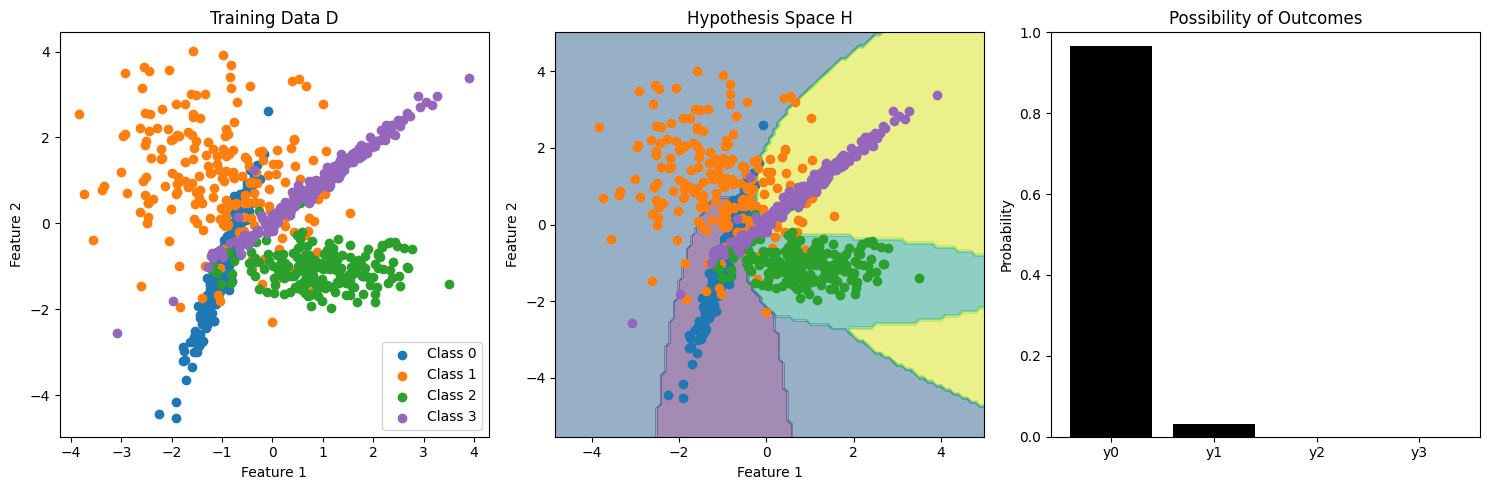

In [9]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_probs = gnb.predict_proba(X_test)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
for i, color in enumerate(colors):
    ax[0].scatter(X_train[y_train == i][:, 0], X_train[y_train == i][:, 1], color=color, label=f'Class {i}')
ax[0].set_title("Training Data D")
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")
ax[0].legend()

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[1].contourf(xx, yy, Z, alpha=0.5, cmap='viridis') 
for i, color in enumerate(colors):
    ax[1].scatter(X_train[y_train == i][:, 0], X_train[y_train == i][:, 1], color=color)
ax[1].set_title("Hypothesis Space H")
ax[1].set_xlabel("Feature 1")
ax[1].set_ylabel("Feature 2")

outcomes = [f'y{i}' for i in range(4)]
probs = y_probs[0] 
ax[2].bar(outcomes, probs, color='black') # tab:blue
ax[2].set_title("Possibility of Outcomes")
ax[2].set_ylabel("Probability")
ax[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

<div align="justify">

More specifically, the representation of uncertainty about a prediction $\haty_{q}$ is given by the image of the posterior $p( h \vert \cD)$ under the mapping $h \mapsto p(y \vert \vec{x}_{q}, h)$ from hypotheses to probabilities of outcomes. This yields the predictive posterior distribution

$$
p(y \vert \vec{x}_{q}) = 
\int_\cH p(y \vert \vec{x}_{q} , h) \, d\, p(h \vert \set{D}) \enspace .
$$(pd)

In this type of (proper) Bayesian inference, a final prediction is thus produced by *model averaging*: The predicted probability of an outcome $y \in \cY$ is the *expected* probability $p(y \vert \vec{x}_{q}, h)$, where the expectation over the hypotheses is taken with respect to the posterior distribution on $\cH$; or, stated differently, the probability of an outcome is a weighted average over its probabilities under all hypotheses in $\cH$, with the weight of each hypothesis $h$ given by its posterior probability $p( h \vert \cD)$.
Since model averaging is often difficult and computationally costly, sometimes only the single hypothesis

$$
h^{map} := \argmax_{h \in \cH} p( h \vert \cD) 
$$(map)

with the highest posterior probability is adopted, and predictions on outcomes are derived from this hypothesis. 

</div>

<div align="justify">

To further understand how Bayesian inference can be applied, let's see a practical example that utilizes advanced probabilistic programming with [PyMC](https://www.pymc.io/welcome.html) library for a more streamlined approach. The following section breaks down the process, from data generation to model estimation and analysis, highlighting the advantages of Bayesian methods in statistical modeling.[^footNoteIdentifier1]

</div>

<div align="justify">

First, we need to generate a set of simulated data to mimic the relationship between house area and selling price. This data will serve as the input for our model, helping us understand how changes in house size could potentially affect pricing.

</div>

In [10]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Generating house area data from 50 to 250 square meters
area = np.linspace(50, 250, 200) 
# Basic price as the intercept at $100,000
intercept = 100  
# Price increase per square meter as the slope
slope = 2 
# Adding normally distributed noise to simulate real-world data variability
noise = rng.normal(scale=20, size=200) 

true_line = intercept + slope * area

price = intercept + slope * area + noise
data = pd.DataFrame({'area': area, 'price': price})

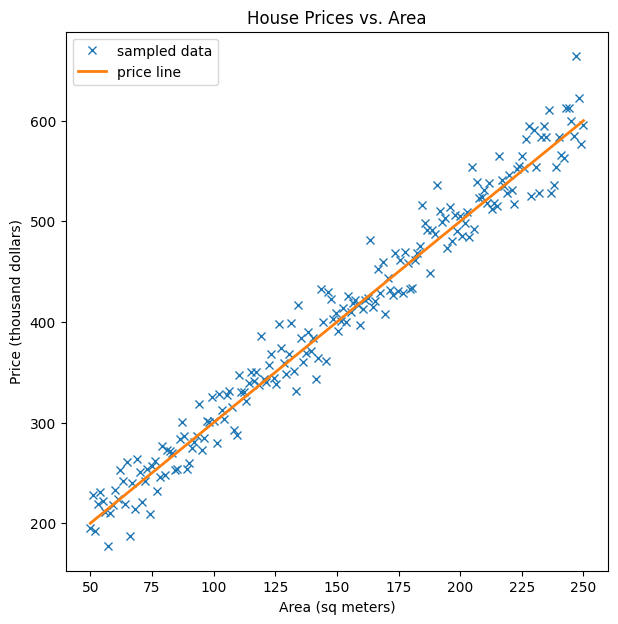

In [11]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="Area (sq meters)", ylabel="Price (thousand dollars)", title="House Prices vs. Area")
ax.plot(area, price, "x", label="sampled data")
ax.plot(area, true_line, label="price line", lw=2.0)
plt.legend(loc=0);

<div align="justify">

Using PyMC, we define a Bayesian linear regression model. We set priors for the intercept, slope, and the noise level, and then use these priors along with the observed data to estimate the posterior distributions. To infer the posterior distributions of the model parameters, 1000 samples are drawn using the NUTS (No-U-Turn Sampler) algorithm. NUTS is an advanced MCMC sampling technique that efficiently handles the complexities of continuous parameter spaces and dependencies among parameters.

</div>

In [12]:
with pm.Model() as model:
    # Priors for unknown model parameters
    sigma = pm.HalfCauchy('sigma', beta=10)
    intercept = pm.Normal('Intercept', 100, sigma=50)
    slope = pm.Normal('Slope', 2, sigma=1)

    # Linear model
    price_est = intercept + slope * data['area']
    # Likelihood (sampling distribution) of observations
    likelihood = pm.Normal('price', mu=price_est, sigma=sigma, observed=data['price'])

    # Drawing 1000 posterior samples using NUTS sampler
    trace =pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Slope]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


<div align="justify">

After sampling, it's useful to visualize the posterior distributions of the model parameters to assess their uncertainty and the convergence of the sampling process.

</div>

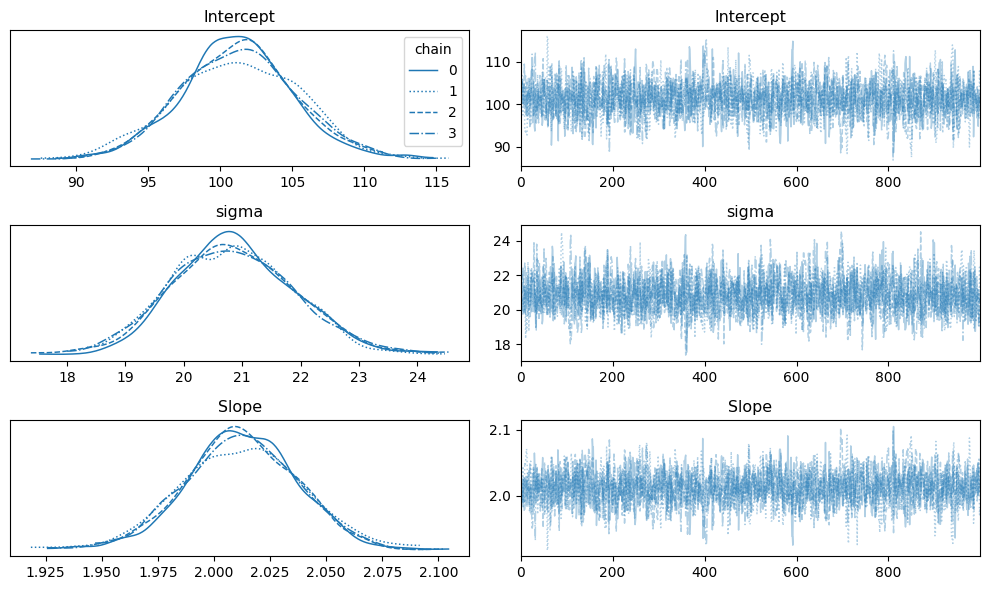

In [13]:
az.plot_trace(trace, var_names=['Intercept', 'sigma', 'Slope'], figsize=(10, 6), legend=True)
plt.tight_layout()

<div align="justify">

Finally, we generate posterior predictive checks to see how well our model predicts new data. This step is crucial for validating the model's performance and understanding its predictive capabilities.
In this approach, instead of relying on a single best-fitting regression line, we consider multiple possible lines. This is visualized through a posterior predictive plot, which illustrates each potential regression line by using different sets of sampled parameters, intercepts and slopes, from the posterior distribution. We can create these lines manually by directly utilizing the posterior samples.

</div>

In [14]:
trace.posterior["y_model"] = trace.posterior["Intercept"] + trace.posterior["Slope"] * xr.DataArray(area)

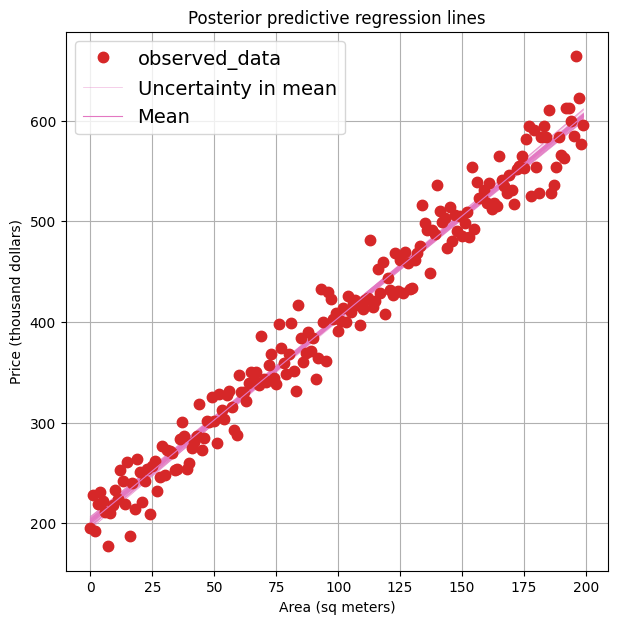

In [26]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=trace, y="price", num_samples=50, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("Area (sq meters)")
ax.set_ylabel('Price (thousand dollars)');

<div align="justify">

In {eq}`pd`, aleatoric and epistemic uncertainty are not distinguished any more, because epistemic uncertainty is "averaged out." Consider the example of coin flipping, and let the hypothesis space be given by $\mathcal{H} \{ h_\alpha \with 0 \leq \alpha \leq 1 \}$, where $h_\alpha$ is modeling a biased coin landing heads up with a probability of $\alpha$ and tails up with a probability of $1- \alpha$. According to {eq}`pd`, we derive a probability of $1/2$ for heads and tails, regardless of whether the (posterior) distribution on $\mathcal{H}$ is given by the uniform distribution (all coins are equally probable, i.e., the case of complete ignorance) or the one-point measure assigning probability 1 to $h_{1/2}$ (the coin is known to be fair with complete certainty):

$$
p(y ) = 
\int_\cH \alpha \, d\, p  = \frac{1}{2} = \int_\cH \alpha \, d\, p'  
$$

for the uniform measure $p$ (with probability density function $p(\alpha) \equiv 1$) as well as the measure $p'$ with probability mass function $p'(\alpha) = 1$ if $\alpha = \frac{1}{2}$ and $= 0$ for $\alpha \neq \frac{1}{2}$. 
Obviously, MAP inference {eq}`map` does not capture epistemic uncertainty either. 

</div>

<div align="justify">

More generally, consider the case of binary classification with $\cY \{ -1, +1 \}$ and $p_h(+1 \vert \vec{x}_{q})$ the probability predicted by the hypothesis $h$ for the positive class. Instead of deriving a distribution on $\mathcal{Y}$ according to {eq}`pd`, one could also derive a predictive distribution for the (unknown) probability $q p(+1 \vert \vec{x}_q)$ of the positive class:

$$
p(q \vert \vec{x}_{q}) = 
\int_{\mathcal{H}} \, \llbracket \, p(+1 \vert \vec{x}_{q} , h) = q \, \rrbracket \, d\, p(h \vert \mathcal{D}) \enspace .
$$(sop)

This is a second-order probability, which still contains both aleatoric and epistemic uncertainty. The question of how to quantify the epistemic part of the uncertainty is not at all obvious, however. Intuitively, epistemic uncertainty should be reflected by the variability of the distribution {eq}`sop`: the more spread the probability mass over the unit interval, the higher the uncertainty seems to be. But how to put this into quantitative terms? Entropy is arguably not a good choice, for example, because this measure is invariant against redistribution of probability mass. For instance, the distributions $p$ and $p'$ with
$p(q \vert \vec{x}_{q}) 12(q-\frac{1}{2})^2$ and $p'(q \vert \vec{x}_{q})  3 - p(q \vert \vec{x}_{q})$ both have the same entropy, although they correspond to quite different states of information. 
From this point of view, the variance of the distribution would be better suited, but this measure has other deficiencies (for example, it is not maximized by the uniform distribution, which could be considered as a case of minimal informedness).  

 
The difficulty of specifying epistemic uncertainty in the Bayesian approach is rooted in the more general difficulty of representing a lack of knowledge in probability theory. This issue will be discussed next.

</div>

(rlk)= 
## Representing a lack of knowledge

<div align="justify">

As already said, uncertainty is captured in a purely *set-based* way in version space learning: $\mathcal{V} \subseteq \mathcal{H}$ is a set of candidate hypotheses, which translates into a set of candidate outcomes $Y \subseteq \mathcal{Y}$ for a query $\vec{x}_{q}$. In the case of sets, there is a rather obvious correspondence between the degree of uncertainty in the sense of a lack of knowledge and the size of the set of candidates: Proceeding from a reference set $\Omega$ of alternatives, assuming some ground-truth $\omega^* \in \Omega$, and expressing knowledge about the latter in terms of a subset $C \subseteq \Omega$ of possible candidates, we can clearly say that the bigger $C$, the larger the lack of knowledge. More specifically, for finite $\Omega$, a common uncertainty measure in information theory is $\log(|C|)$. Consequently, knowledge gets weaker by adding additional elements to $C$ and stronger by removing candidates. 

In standard probabilistic modeling and Bayesian inference, where knowledge is conveyed by a distribution $p$ on $\Omega$, it is much less obvious how to "weaken" this knowledge. This is mainly because the total amount of belief is fixed in terms of a unit mass that can be distributed among the elements $\omega \in \Omega$. Unlike for sets, where an additional candidate $\omega$ can be added or removed without changing the plausibility of all other candidates, increasing the weight of one alternative $\omega$ requires decreasing the weight of another alternative $\omega'$ by exactly the same amount. 

</div>

<div align="justify">

Of course, there are also measures of uncertainty for probability distributions, most notably the (Shannon) entropy, which, for finite $\Omega$, is given as follows:

$$
H(p) := - \sum_{\omega \in \Omega} p(\omega) \, \log p(\omega)  
$$(shannon)

However, these measures are primarily capturing the shape of the distribution, namely its "peakedness" or non-uniformity ({cite:t}`mpub128`), and hence inform about the predictability of the outcome of a random experiment. Seen from this point of view, they are more akin to aleatoric uncertainty, whereas the set-based approach (i.e., representing knowledge in terms of a subset $C \subseteq \Omega$ of candidates) is arguably better suited for capturing epistemic uncertainty. 

</div>

<div align="justify">

For these reasons, it has been argued that probability distributions are less suitable for representing *ignorance* in the sense of a lack of knowledge ({cite:t}`dubo_rp96`). For example, the case of *complete ignorance* is typically modeled in terms of the uniform distribution $p \equiv 1/|\Omega|$ in probability theory; this is justified by the "principle of indifference" invoked by Laplace, or by referring to the principle of maximum entropy[^footNoteIdentifier2]. Then, however, it is not possible to distinguish between (i) precise (probabilistic) knowledge about a random event, such as tossing a fair coin, and (ii) a complete lack of knowledge due to an incomplete description of the experiment.
This was already pointed out by the famous Ronald Fisher, who noted that "*not knowing the chance of mutually exclusive events and knowing the chance to be equal are two quite different states of knowledge*."

Another problem in this regard is caused by the measure-theoretic grounding of probability and its additive nature. For example, the uniform distribution is not invariant under reparametrization (a uniform distribution on a parameter $\omega$ does not translate into a uniform distribution on $1/\omega$, although ignorance about $\omega$ implies ignorance about $1/\omega$). Likewise, expressing ignorance about the length $x$ of a cube in terms of a uniform distribution on an interval $[l,u]$ does not yield a uniform distribution of $x^3$ on $[l^3 , u^3]$, thereby suggesting some degree of informedness about its volume. Problems of this kind render the use of a uniform prior distribution, often interpreted as representing epistemic uncertainty in Bayesian inference, at least debatable[^footNoteIdentifier3].

</div>

<div align="justify">

The argument that a single (probability) distribution is not enough for representing uncertain knowledge is quite prominent in the literature. Correspondingly, various generalizations of standard probability theory have been proposed, including imprecise probability ({cite:t}`wall_sr`), evidence theory ({cite:t}`shaf_am,smet_tt94`), and possibility theory ({cite:t}`dubo_pt`). These formalisms are essentially working with sets of probability distributions, i.e., they seek to take advantage of the complementary nature of sets and distributions, and to combine both representations in a meaningful way (cf. {numref}`setting2`). There is a brief overview in next chapter. 

</div>

:::{figure-md} setting2
<img src="pic-settings.png" alt="settings" width="600px">

Set-based versus distributional knowledge representation on the level of predictions, hypotheses, and models. In version space learning, the model class is fixed, and knowledge about hypotheses and outcomes is represented in terms of sets (blue color). In Bayesian inference, sets are replaced by probability distributions (gray shading). Theories like possibility and evidence theory are in-between, essentially working with sets of distributions. Credal inference (cf. Section [Credal Sets and Classifiers](../chapter-credal_sets/credal_sets) ) generalizes Bayesian inference by replacing a single prior with a set of prior distributions (here identified by a set of hyper-parameters). In hierarchical Bayesian modeling, this set is again replaced by a distribution, i.e., a second-order probability.
:::

## Set-based versus distributional representations

(unc)=
### Background on uncertainty modeling

<div align="justify">

The notion of uncertainty has been studied in various branches of science and scientific disciplines. For a long time, it plays a major role in fields like economics, psychology, and the social sciences, typically in the appearance of applied statistics. Likewise, its importance for artificial intelligence has been recognized very early on[^footNoteIdentifier4], at the latest with the emergence of expert systems, which came along with the need for handling inconsistency, incompleteness, imprecision, and vagueness in knowledge representation ({cite:t}`krus_ua`). More recently, the phenomenon of uncertainty has also attracted a lot of attention in engineering, where it is studied under the notion of "uncertainty quantification"  ({cite:t}`owha_ou12`); interestingly, a distinction between aleatoric and epistemic uncertainty, very much in line with our machine learning perspective, is also made there.

</div>

<div align="justify">

The contemporary literature on uncertainty is rather broad (cf. {numref}`calcu`). In the following, we give a brief overview, specifically focusing on the distinction between set-based and distributional (probabilistic) representations. Against the background of our discussion about aleatoric and epistemic uncertainty, this distinction is arguably important. Roughly speaking, while aleatoric uncertainty is appropriately modeled in terms of probability distributions, one may argue that a set-based approach is more suitable for modeling ignorance and a lack of knowledge, and hence more apt at capturing epistemic uncertainty.

</div>

:::{figure-md} calcu
<img src="pic-calculi.png" alt="calculi" width="600px">

Various uncertainty calculi and common frameworks for uncertainty representation ({cite:t}`dest_up08`). Most of these formalisms are generalizations of standard probability theory an arrow denotes an "is more general than" relationship
:::

### Sets versus distributions

<div align="justify">

A generic way for describing situations of uncertainty is to proceed from an underlying reference set $\Omega$, sometimes called the *frame of discernment* ({cite:t}`shaf_am`). This set consists of all hypotheses, or pieces of precise information, that ought to be distinguished in the current context.  Thus, the elements $\omega \in \Omega$ are exhaustive and mutually exclusive, and one of them, $\omega^*$, corresponds to the truth. For example, $\Omega = \{ H, T \}$ in the case of coin tossing, $\Omega = \{ \text{win}, \text{loss}, \text{tie} \}$ in predicting the outcome of a football match, or $\Omega = \mathbb{R} \times \mathbb{R}_+$ in the estimation of the parameters (expected value and standar deviation) of a normal distribution from data. For ease of exposition and to avoid measure-theoretic complications, we will subsequently assume that $\Omega$ is a discrete (finite or countable) set. 


</div>

In [16]:
football_omega = ["win", "tie","loss"]

<div align="justify">

As an aside, we note that the assumption of exhaustiveness of $\Omega$ could be relaxed. In a classification problem in machine learning, for example, not all possible classes might be known beforehand, or new classes may emerge in the course of time({cite:t}`hend_ab17`; {cite:t}`lian_et18`; {cite:t}`devr_lc18`). In the literature, this is often called the "open world assumption", whereas an exhaustive $\Omega$ is considered as a "closed world" ({cite:t}`deng_ge14`). Although this distinction may look technical at first sight, it has important consequences with regard to the representation and processing of uncertain information, which specifically concern the role of the empty set. While the empty set is logically excluded as a valid piece of information under the closed world assumption, it may suggest that the true state $\omega^*$ is outside $\Omega$ under the open world assumption.

</div>

<div align="justify">

There are two basic ways for expressing uncertain information about $\omega^*$, namely, in terms of *subsets* and in terms of *distributions*. A subset $C \subseteq \Omega$ corresponds to a constraint suggesting that $\omega^* \in C$. Thus, information or knowledge[^footNoteIdentifier5] expressed in this way distinguishes between values that are (at least provisionally) considered possible and those that are definitely excluded. As suggested by common examples such as specifying incomplete information about a numerical quantity in terms of an interval $C= [l,u]$, a set-based representation is appropriate for capturing uncertainty in the sense of *imprecision*. 


Going beyond this rough dichotomy, a distribution assigns a weight $p(\omega)$ to each element $\omega$, which can generally be understood as a degree of belief. At first sight, this appears to be a proper generalization of the set-based approach. Indeed, without any constraints on the weights, each subset $C$ can be characterized in terms of its indicator function $\mathbb{I}_C$ on $\Omega$ (which is a specific distribution assigning a weight of 1 to each $\omega \in C$ and 0 to all $\omega \not\in \Omega$). However, for the specifically important case of probability distributions, this view is actually not valid. 

</div>

<div align="justify">

First, probability distributions need to obey a normalization constraint. In particular, a probability distribution requires the weights to be nonnegative and integrate to 1. A corresponding probability measure on $\Omega$ is a set-function $\Prob: \, 2^\Omega \longrightarrow [0,1]$ such that $\Prob(\emptyset) = 0$, $\Prob(\Omega)=1$, and 

$$
\Prob(A \cup B) = \Prob(A) + \Prob(B) 
$$(addi1)

for all disjoint sets (events) $A, B \subseteq \Omega$. With $\prob(\omega) = \Prob(\{ \omega \})$ for all $\omega \in \Omega$ it follows that $\Prob(A) = \sum_{\omega \in A} \prob(\omega)$, and hence $\sum_{\omega \in \Omega} \prob(\omega)=1$. Since the set-based approach does not (need to) satify this constraint, it is no longer a special case.

Let us now define a probability distribution for the outcomes of a football match, i.e. $\Omega = \{ \text{win}, \text{loss}, \text{tie} \}$ with 
$\Prob(\{\text{win} \}) = 0.5$ and $\Prob(\{\text{loss} \}) = \Prob(\{\text{tie} \}) = 0.25$. Then we can easily calculate the probability for all subsets $S\subseteq \Omega$:

</div>

In [27]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def probability_distribution_football(event):
    match event:
        case "":
            return 0
        case "win":
            return 0.5
        case "tie":
            return 0.25
        case "loss":
            return 0.25
        case _:
            return sum([probability_distribution_football(e) for e in event])

probability_values = {
    x:round(probability_distribution_football(x),3)
    for x in list(powerset(football_omega))
}
probability_values

{(): 0,
 ('win',): 0.5,
 ('tie',): 0.25,
 ('loss',): 0.25,
 ('win', 'tie'): 0.75,
 ('win', 'loss'): 0.75,
 ('tie', 'loss'): 0.5,
 ('win', 'tie', 'loss'): 1.0}

| S    | $\Prob(S)$    |
| :--- | ---: |
| {}    | 0 |
| {win} | 0.5|
| {loss} |0.25 |
| {tie} | 0.25 |
| {win,tie} |   0.75 |
| {win,loss} | 0.75 |
| {loss,tie} | 0.5 |
| {win,loss,tie} | 1|

<div align="justify">

Second, in addition to the question of how information is represented, it is of course important to ask how the information is processed. In this regard, the probabilistic calculus differs fundamentally from constraint-based (set-based) information processing. The characteristic property of probability is its additivity {eq}`addi1`, suggesting that the belief in the disjunction (union) of two (disjoint) events $A$ and $B$ is the sum of the belief in either of them. In contrast to this, the set-based approach is more in line with a logical interpretation and calculus. Interpreting a constraint $C$ as a logical proposition $(\omega \in C)$, an event $A \subseteq \Omega$ is possible as soon as $A \cap C \neq \emptyset$ and impossible otherwise. Thus, the information $(\omega \in C)$ can be associated with a set-function $\Pi:\, 2^\Omega \longrightarrow \{ 0, 1 \}$ such that $\Pi(A) = \llbracket A \cap C \neq \emptyset \rrbracket$. Obviously, this set-function satisfies $\Pi(\emptyset) = 0$, $\Pi(\Omega) = 1$, and 

$$
\Pi(A \cup B) = \max \big( \Pi(A) , \Pi(B) \big) 
$$(maxi1)

Thus, $\Pi$ is "maxitive" instead of additive ({cite:t}`shil_mm71`;{cite:t}`dubo_pt06`). Roughly speaking, an event $A$ is evaluated according to its (logical) consistency with a constraint $C$, whereas in probability theory, an event $A$ is evaluated in terms of its probability of occurrence. The latter is reflected by the probability mass assigned to $A$, and requires a comparison of this mass with the mass of other events (since only one outcome $\omega$ is possible, the elementary events compete with each other). Consequently, the calculus of probability, including rules for combination of information, conditioning, etc., is quite different from the corresponding calculus of constraint-based information processing ({cite:t}`dubo_pt06`).

For our football example we choose $C = \{ \text{win}, \text{tie} \}$ and the resulting values of the subsets can be easily computed:
</div>

In [18]:
constraint = ["win","tie"]

def pi_function(event):
    # the np.any takes over the role of the max()
    # the (1*) is to convert the output directly into a number
    return 1* np.any([e in constraint for e in event])


constraint_based_information = {
    x:round(pi_function(x),3)
    for x in list(powerset(football_omega))
}
constraint_based_information

{(): 0,
 ('win',): 1,
 ('tie',): 1,
 ('loss',): 0,
 ('win', 'tie'): 1,
 ('win', 'loss'): 1,
 ('tie', 'loss'): 1,
 ('win', 'tie', 'loss'): 1}

| S    | $\Pi(S)$    |
| :--- | ---: |
| {}    | 0  |
| {win} | 1 |
| {loss} | 0 |
| {tie} | 1 |
| {win,tie} |   1 |
| {win,loss} | 1 |
| {loss,tie} | 1 |
| {win,loss,tie} | 1|

### Sets of distributions

<div align="justify">

Given the complementary nature of sets and distributions, and the observation that both have advantages and disadvantages, one may wonder whether the two could not be combined in a meaningful way. Indeed, the argument that a single (probability) distribution is not enough for representing uncertain knowledge is quite prominent in the literature, and many generalized theories of uncertainty can be considered as a combination of that kind ({cite:t}`pdubo_pt`;{cite:t}`wall_sr`;{cite:t}`shaf_am`;{cite:t}`smet_tt94`). 

Since we are specifically interested in aleatoric and epistemic uncertainty, and since these two types of uncertainty are reasonably captured in terms of sets and probability distributions, respectively, a natural idea is to consider *sets of probability distributions*. In the literature on imprecise probability, these are also called [credal sets](../chapter-credal_sets/credal_sets) ({cite:t}`cozm_cn00`;{cite:t}`zaff_tn02`). An illustration is given in {numref}`bary1`, where probability distributions on $\Omega = \{ a,b,c \}$ are represented as points in a Barycentric coordinate systems. A credal set then corresponds to a subset of such points, suggesting a lack of knowledge about the true distribution but restricting it in terms of a set of possible candidates.  

</div>

:::{figure-md} bary1
<img src="pic-bary.png" alt="settings" width="600px">

Probability distributions on $\Omega = \{ a,b,c \}$ as points in a Barycentric coordinate system: Precise knowledge (left) versus incomplete knowledge (middle) and complete ignorance (right) about the true distribution.
:::

<div align="justify">

Credal sets are typically assumed to be convex subsets of the class $\mathbb{P}$ of all probability distributions on $\Omega$. Such sets can be specified in different ways, for example in terms of upper and lower bounds on the probabilities $\Prob(A)$ of events $A \subseteq \Omega$. A specifically simple approach (albeit of limited expressivity) is the use of so-called *possibility distributions* and related *possibility measures* ({cite:t}`dubo_pt`). A possibility distribution is a mapping $\pi: \, \Omega \longrightarrow [0,1]$, and the associated measure is given by 

$$
\Pi: \, 2^\Omega \longrightarrow [0,1], \, A \mapsto \sup_{\omega \in A} \pi(\omega) \, .
$$

</div>

<div align="justify">

A measure of that kind can be interpreted as an upper bound, and thus defines a set $\mathcal{P}$ of dominated probability distributions:

$$
\mathcal{P} := \big\{ \Prob \in \mathbb{P} \vert \Prob(A) \leq \Pi(A) \text{ for all } A \subseteq \Omega \big\}
$$

Formally, a possibility measure on $\Omega$ satisfies $\Pi(\emptyset)=0$, $\Pi(\Omega)=1$, and $\Pi(A \cup B) = \max(\Pi(A), \Pi(B))$ for all $A, B \subseteq \Omega$. Thus, it generalizes the maxitivity {eq}`maxi1` of sets in the sense that $\Pi$ is not (necessarily) an indicator function, i.e., $\Pi(A)$ is in $[0,1]$ and not restricted to $\{ 0, 1 \}$. A related *necessity measure* is defined as $N(A) = 1 - \Pi(\bar{A})$, where $\bar{A} = \Omega \setminus A$. Thus, an event $A$ is plausible insofar as the complement of $A$ is not necessary. Or, stated differently, an event $A$ necessarily occurs if the complement of $A$ is not possible. 

Let us again compute the possibility measures $\Pi$ for the football example with $\pi(\text{win}) = 0.9, \pi(\text{tie}) = 0.7$ and $\pi(\text{loss}) = 0.3$:

</div>

In [30]:
def possibility_measure_football(event):
    match event:
        case "":
            return 0
        case "win":
            return 0.9
        case "tie":
            return 0.7
        case "loss":
            return 0.3
        case _:
            values = [probability_distribution_football(e) for e in event]
            if len(values) == 0:
                return 0
            else:
                return max([possibility_measure_football(e) for e in event])

possibility_values = {
    x:round(possibility_measure_football(x),3)
    for x in list(powerset(football_omega))
}
possibility_values

{(): 0,
 ('win',): 0.9,
 ('tie',): 0.7,
 ('loss',): 0.3,
 ('win', 'tie'): 0.9,
 ('win', 'loss'): 0.9,
 ('tie', 'loss'): 0.7,
 ('win', 'tie', 'loss'): 0.9}

| S    | $\Pi(S)$    |
| :--- | ---: |
| {}    | 0|
| {win} | 0.9 |
| {loss} | 0.3 |
| {tie} | 0.7 |
| {win,tie} | 0.9 |
| {win,loss} | 0.9 |
| {loss,tie} | 0.7 |
| {win,loss,tie} | 0.9|

<div align="justify">

We take $C = \{ \text{win}, \text{tie} \}$ as an example. So the complement of $C$ is $\bar{C} = \Omega \setminus C = \{ \text{loss}\}$. The neccessity measure $N(C) = 1 - \Pi(\bar{C}) = 0.7$

</div>

<div align="justify">

In a sense, possibility theory combines aspects of both set-based and distributional approaches. In fact, a possibility distribution can be seen as both a generalized set (in which elements can have graded degrees of membership) and a non-additive measure. Just like a probability, it allows for expressing graded degrees of belief (instead of merely distinguishing possible from impossible events), but its calculus is maxitive instead of additive[^footNoteIdentifier6].

The dual pair of measures $(N, \Pi)$ allows for expressing ignorance in a proper way, mainly because $A$ can be declared plausible without declaring $\bar{A}$ implausible. In particular, $\Pi(A) \equiv 1$ on $2^\Omega \setminus \emptyset$ models complete ignorance: Everything is fully plausible, and hence nothing is necessary ($N(A) = 1 - \Pi(\bar{A}) = 0$ for all $A$). A probability measure, on the other hand, is self-dual in the sense that $\Prob(A) = 1 - \Prob(\bar{A})$. Thus, a probability measure is playing both roles simultaneously, namely the role of the possibility and the role of the necessity measure. Therefore, it is more constrained than a representation $(N, \Pi)$. In a sense, probability and possibility distributions can be seen as two extremes on the scale of uncertainty representations[^footNoteIdentifier7].

</div>

In [32]:
def necessity_measure_football(event):
    event_complement  = [e for e in football_omega if e not in event]
    return 1 - possibility_measure_football(event_complement)

necessity_values = {
    x: round(necessity_measure_football(x),3)
    for x in list(powerset(football_omega))
}
necessity_values

{(): 0.1,
 ('win',): 0.3,
 ('tie',): 0.1,
 ('loss',): 0.1,
 ('win', 'tie'): 0.7,
 ('win', 'loss'): 0.3,
 ('tie', 'loss'): 0.1,
 ('win', 'tie', 'loss'): 1}

| S    | $\Pi(S)$    | $N(S)$ |
| :--- | --- | ---:| 
| {}    | 0| 0.1|
| {win} | 0.9 | 0.3|
| {loss} | 0.7 |0.1 | 
| {tie} | 0.3 | 0.1|
| {win,tie} | 0.9 | 0.7|
| {win,loss} | 0.9 | 0.3|
| {loss,tie} | 0.7 | 0.1|
| {win,loss,tie} | 0.9 | 1|

(dos)=
### Distributions of sets

<div align="justify">

Sets and distributions can also be combined the other way around, namely in terms of distributions of sets. Formalisms based on this idea include the calculus of *random sets* ({cite:t}`math_rs`;{cite:t}`nguy_or78`) as well as the Dempster-Shafer theory of evidence ({cite:t}`shaf_am`).

In evidence theory, uncertain information is again expressed in terms of a dual pair of measures on $\Omega$, a measure of *plausibility* and a measure of *belief*. Both can be derived from an underlying *mass function* or *basic belief assignment* $m:\, 2^\Omega \longrightarrow [0,1]$, for which $m(\emptyset) = 0$ and $\sum_{B \subseteq \Omega} m(B) = 1$. Obviously, $m$ defines a probability distribution on the subsets of $\Omega$. Thus, instead of a single set or constraint $C$, like in the set-based approach, we are now dealing with a set of such constraints, each one being assigned a weight $m(C)$. Each $C \subseteq \Omega$ such that $m(C) > 0$ is called a *focal element* and represents a single piece of evidence (in favor of $\omega^* \in C$). Assigning masses to subsets $C$ instead of single elements $\omega$ allows for combining randomness and imprecision. 

Let us now define a mass assignment $m$ with $m(\{\text{win}\}) = 0.3, m(\emptyset) = 0, m(\{\text{win}, \text{tie}\}) = 0.5 $ and $m(\{ \text{tie}, \text{loss} \}) = 0.2$. $\emptyset$ is not a focal element because the weight is not > 0.

</div>

<div align="justify">

A plausibility and belief function are derived from a mass function $m$ as follows: 

$$
\on{Pl}(A) := \sum_{B \cap A \neq \emptyset} m(B)  \, ,  \quad
\on{Bel}(A) := \sum_{B \subseteq A } m(B) \, .
$$

So the belief and plausibility values for the defined mass assignments are:

</div>

In [33]:
def mass_assignment(events):
    match events:
        case ("win",):
            return 0.3
        case ("win","tie"):
            return 0.5
        case ("tie","loss"):
            return 0.2
        case _:
            return 0
        
def plausibility_measure(events):
    plausibility = 0
    for e in list(powerset(football_omega)):
        if set(e).intersection(set(events)) != set():
            plausibility += mass_assignment(e)
    return plausibility

def belief_measure(events):
    belief = 0
    for e in list(powerset(events)):
        belief += mass_assignment(e)
    return belief

plausibility_values = {
    x: round(plausibility_measure(x),3)
    for x in list(powerset(football_omega))
}
belief_values = {    
    x: round(belief_measure(x),3)
    for x in list(powerset(football_omega))
}
plausibility_values, belief_values

({(): 0,
  ('win',): 0.8,
  ('tie',): 0.7,
  ('loss',): 0.2,
  ('win', 'tie'): 1.0,
  ('win', 'loss'): 1.0,
  ('tie', 'loss'): 0.7,
  ('win', 'tie', 'loss'): 1.0},
 {(): 0,
  ('win',): 0.3,
  ('tie',): 0,
  ('loss',): 0,
  ('win', 'tie'): 0.8,
  ('win', 'loss'): 0.3,
  ('tie', 'loss'): 0.2,
  ('win', 'tie', 'loss'): 1.0})

| S    | $\on{Pl}(S)$    | $\on{Bel}(S)$ |
| :--- | --- | ---:| 
| {}    | 0| 0|
| {win} | 0.8 | 0.3|
| {loss} | 0.2 |0 | 
| {tie} | 0.7 | 0|
| {win,tie} | 1 | 0.8|
| {win,loss} | 1 | 0.3|
| {loss,tie} | 0.7 | 0.2|
| {win,loss,tie} | 1 | 1|

<div align="justify">

Plausibility (or belief) functions indeed generalize both probability and possibility distributions. A probability distribution is obtained in the case where all focal elements are singleton sets. We still take the football match as an example. $\Omega = \{ \text{win}, \text{loss}, \text{tie} \}$ and $m(\{\text{win} \}) = 0.5$ and $m(\{\text{loss} \}) =0.2$ $m(\{\text{tie} \}) = 0.3$, this is actually a probability distribution. 

A possibility measure is obtained as a special case of a plausibility measure (and, correspondingly, a necessity measure as a special case of a belief measure) for a mass function the focal sets of which are nested, i.e., such that $C_1 \subset C_2 \subset \cdots \subset C_r$. The corresponding possibility distribution is the *contour function* of the plausibility measure: $\pi(\omega) = \on{Pl}(\{ \omega\}) := \sum_{C : \, \omega \in C} m(C)$ for all $\omega \in \Omega$. Thus, $\pi(\omega)$ can be interpreted as the probability that $\omega$ is contained in a subset $C$ that is randomly chosen according to the distribution $m$ (see {numref}`contour1` for an illustration).  

We further calculte the possibility distribution based on the previous mass assignment: $m(\{\text{win}\}) = 0.3, m(\{\text{win}, \text{tie}\}) = 0.5 $ and $m(\{ \text{tie}, \text{loss} \}) = 0.2$ and $\pi(\text{win}) = \on{Pl}(\{ \text{win}\}) := m(\{\text{win}\}) + m(\{\text{win}, \text{tie}\}) = 0.8$. Below is the visualization of possibility distribution. 

</div>

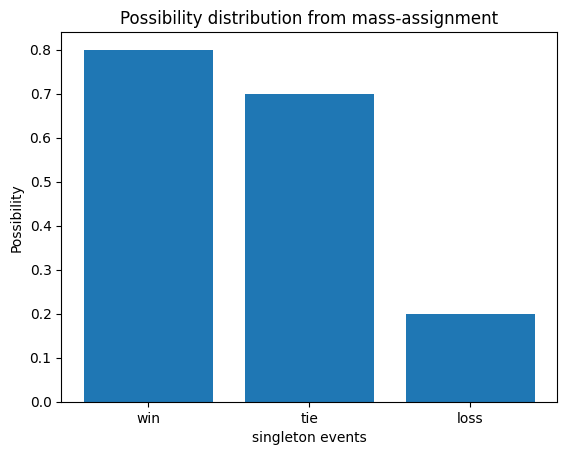

In [ ]:
possibility_values = {
    x:plausibility_measure((x,))
    for x in football_omega
}
possibility_distribution = possibility_values.values()

fig, ax = plt.subplots()

ax.bar(x=football_omega,height=possibility_distribution)

ax.set_title("Possibility distribution from mass-assignment")
ax.set_xlabel("Events")
ax.set_ylabel("Possibility")
plt.show()

:::{figure-md} contour1
<img src="pic-contour.png" alt="contour" width="600px">

Possibility distribution as a contour function of a basic belief assignment $m$ (values assigned to focal sets on the right). In this example, $\pi(\omega_5)=1$, because $\omega_5$ is contained in all focal sets, whereas $\pi(\omega_3)=0.6$.
:::

<div align="justify">

Note that we have obtained a possibility distribution in two ways and for two different interpretations, representing a set of distributions as well as a distribution of sets. One concrete way to define a possibility distribution $\pi$ in a data-driven way, which is specifically interesting in the context of statistical inference, is in terms of the *normalized* or *relative likelihood*. Consider the case where $\omega^*$ is the parameter of a probability distribution, and we are interested in estimating this parameter based on observed data $\mathcal{D}$; in other words, we are interested in identifying the distribution within the family $\{ \Prob_\omega \with \omega \in \Omega \}$ from which the data was generated. The likelihood function is then given by $L(\omega; \mathcal{D}) := \Prob_\omega(\mathcal{D})$, and the normalized likelihood as 

$$
L^{n}(\omega; \mathcal{D}) := \frac{L(\omega; \mathcal{D})}{\sup_{\omega' \in \Omega} L(\omega; \mathcal{D})} \enspace .
$$

This function can be taken as the contour function of a (consonant) plausibility function $\pi$, i.e., $\pi(\omega) = L^{n}(\omega; \mathcal{D})$ for all $\omega \in \Omega$; the focal sets then simply correspond to the confidence intervals that can be extracted from the likelihood function, which are of the form $C_\alpha = \{ \omega \with L^{n}(\omega; \mathcal{D}) \geq \alpha \}$. This is an interesting illustration of the idea of a distribution of sets: A confidence interval can be seen as a constraint, suggesting that the true parameter is located inside that interval. However, a single (deterministic) constraint is not meaningful, since there is a tradeoff between the correctness and the precision of the constraint. Working with a set of constraints---or, say, a flexible constraint---is a viable alternative.

</div>

<div align="justify">

The normalized likelihood was originally introduced by {cite:t}`shaf_am`, and has been justified axiomatically in the context of statistical inference by {cite:t}`wass_bf90`. Further arguments in favor of using the relative likelihood as the contour function of a (consonant) plausibility function are provided by {cite:t}`deno_lb14`, who shows that it can be derived from three basic principles: the likelihood principle, compatibility with Bayes' rule, and the so-called minimal commitment principle. See also ({cite:t}`dubo_as97`) and ({cite:t}`catt_ls05`) for a discussion of the normalized likelihood in the context of possibility theory.  

</div>

[^footNoteIdentifier1]:Code is adapted from [PyMC GLM: Linear regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#bayesian-glms-in-pymc)

[^footNoteIdentifier2]:Obviously, there is a technical problem in defining the uniform distribution in the case where $\Omega$ is not finite.

[^footNoteIdentifier3]:This problem is inherited by hierarchical Bayesian modeling. See work on "non-informative" priors, however ({cite:t}`jeff_46`,{cite:t}`bern_rp79`).

[^footNoteIdentifier4]:The "Annual Conference on Uncertainty in Artificial Intelligence" (UAI) was launched in the mid 1980s.

[^footNoteIdentifier5]:We do not distinguish between the notions of information and knowledge in this paper.

[^footNoteIdentifier6]:For this reason, possibility measures can also be defined on non-numerical, purely ordinal structures.

[^footNoteIdentifier7]:Strictly speaking, possibilities are not more expressive than probabilities, since possibility distributions cannot model degenerate probability distributions: $\Pi \neq N$ unless $\Pi(\{ \omega^* \}) = 1$ for some $\omega^* \in \Omega$ and $\Pi(\{ \omega \}) = 0$ otherwise.